# Data analysis for the 2nd exps of UIST 2020

## Loading library and data

In [1]:
library(plyr)
library(nlme)
library(emmeans)
library(boot)
library(multcomp) # for glht and Tukey HSD
library(lme4)     # for glmer
library(nortest)  # for Kolmogorov-Smirnov test
library(car)      # for Anova
library(ez)       # for ezANOVA
library(ARTool)   # For ART

library(ggpubr)
library(grid)
library(gridExtra)

source("helper_functions.R")
source("friedman.R")

options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 80)

Loading required package: mvtnorm

Loading required package: survival


Attaching package: ‘survival’


The following object is masked from ‘package:boot’:

    aml


Loading required package: TH.data

Loading required package: MASS


Attaching package: ‘TH.data’


The following object is masked from ‘package:MASS’:

    geyser


Loading required package: Matrix


Attaching package: ‘lme4’


The following object is masked from ‘package:nlme’:

    lmList


Loading required package: carData

Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4


Attaching package: ‘car’


The following object is masked from ‘package:boot’:

    logit


Loading required package: ggplot2

Loading required package: magrittr


Attaching package: ‘ggpubr’


The following object is masked from ‘package:plyr’:

    mutate




In [2]:
# Function for computing confidence intervals by bootstrating
# https://tonyladson.wordpress.com/2016/02/05/confidence-interval-for-the-mean-of-non-normal-data/

# Wang, F.K. (2001), Confidence interval for the mean of non‐normal data. 
# Quality and Reliability Engingeering International, 17: 257-267.https://doi.org/10.1002/qre.400

# DiCiccio, Thomas J.; Efron, Bradley. Bootstrap confidence intervals. 
# Statist. Sci. 11 (1996), no. 3, 189--228. https://dx.doi.org/10.1214/ss/1032280214

summaryWithBoot <- function(data=NULL, measurevar, groupvars=NULL,
                    conf.interval=.95, type="bca", .drop=TRUE) {
  require(boot)
    
  # function to obtain the mean
  Bmean <- function(data, i) {
      d <- data[i] # allows boot to select sample
      return(mean(d))
  }

  datac <- ddply(data, groupvars, .drop=.drop,
                 .fun = function(xx, col) {
                     bout.out <- boot(data=xx[[col]], statistic=Bmean, R=10000)
                     res <- boot.ci(bout.out, conf=conf.interval, type=c("norm","basic", "perc", "bca"))
                     c(N    = length(xx[[col]]),
                       mean = bout.out$t0,
                       clow = res[[type]][4],
                       cupp = res[[type]][5]
                   )
                 },
                 measurevar
  )
  datac <- rename(datac, c("mean" = measurevar))
  return(datac)
}

In [3]:
# read the data
mydata <- read.csv("Data_exp2.csv")

# create a table with aggregated data
mydata_agg = aggregate(mydata,
                by = list(mydata$roomT, mydata$condition, mydata$id),
                FUN = mean)
mydata_agg[1:3] <- list(NULL)

# create a table with aggregated data by condition
mydata_agg2 = aggregate(mydata_agg,
                by = list(mydata_agg$condition, mydata_agg$id),
                FUN = mean)
mydata_agg2[1:2] <- list(NULL)
mydata_agg2[3] <- list(NULL)

# create a table with aggregated data by roomT
mydata_agg3 = aggregate(mydata_agg,
                by = list(mydata_agg$roomT, mydata_agg$id),
                FUN = mean)
mydata_agg3[1:2] <- list(NULL)
mydata_agg3[2] <- list(NULL)

# define factors in all tables
mydata$id <- as.factor(mydata$id)
mydata$condition <- as.factor(mydata$condition)
mydata$roomT <- as.factor(mydata$roomT)

mydata_agg$id <- as.factor(mydata_agg$id)
mydata_agg$condition <- as.factor(mydata_agg$condition)
mydata_agg$roomT <- as.factor(mydata_agg$roomT)

mydata_agg2$id <- as.factor(mydata_agg2$id)
mydata_agg2$condition <- as.factor(mydata_agg2$condition)

mydata_agg3$id <- as.factor(mydata_agg3$id)
mydata_agg3$roomT <- as.factor(mydata_agg3$roomT)

In [4]:
str(mydata)

'data.frame':	288 obs. of  8 variables:
 $ id              : Factor w/ 12 levels "1","2","3","4",..: 5 5 5 5 5 5 5 5 4 4 ...
 $ condition       : Factor w/ 3 levels "0","1","2": 2 2 2 2 2 2 2 2 2 2 ...
 $ roomT           : Factor w/ 2 levels "0","1": 1 1 1 1 2 2 2 2 2 2 ...
 $ TCT             : num  38720 35336 41049 35164 32416 ...
 $ nb_warning      : int  1 10 0 2 1 2 2 0 1 3 ...
 $ nb_teleportation: int  2 2 2 2 2 3 2 3 3 5 ...
 $ walking         : num  18.05 26.26 19.54 14.86 8.51 ...
 $ rot             : num  2357 2343 2099 2205 1946 ...


In [5]:
head(mydata)

id condition roomT TCT     nb_warning nb_teleportation walking   rot     
1 5  1         0     38720.4  1         2                18.053516 2357.405
2 5  1         0     35336.5 10         2                26.258503 2342.783
3 5  1         0     41048.8  0         2                19.541346 2098.688
4 5  1         0     35163.9  2         2                14.855635 2205.154
5 5  1         1     32416.1  1         2                 8.507107 1945.900
6 5  1         1     40522.8  2         3                16.272792 2168.623

In [6]:
str(mydata_agg)

'data.frame':	72 obs. of  8 variables:
 $ id              : Factor w/ 12 levels "1","2","3","4",..: 1 1 1 1 1 1 2 2 2 2 ...
 $ condition       : Factor w/ 3 levels "0","1","2": 1 1 2 2 3 3 1 1 2 2 ...
 $ roomT           : Factor w/ 2 levels "0","1": 1 2 1 2 1 2 1 2 1 2 ...
 $ TCT             : num  91027 72210 64363 49418 48000 ...
 $ nb_warning      : num  0.5 0.5 1.75 0.5 0 1 1.25 2.75 0 0.25 ...
 $ nb_teleportation: num  20.75 17.5 3.75 6.5 2.25 ...
 $ walking         : num  12.43 2.77 17.31 13.44 16.39 ...
 $ rot             : num  3977 3353 3177 2649 2829 ...


In [7]:
head(mydata_agg)

id condition roomT TCT      nb_warning nb_teleportation walking  rot     
1 1  0         0     91026.90 0.50       20.75            12.42855 3976.551
2 1  0         1     72210.35 0.50       17.50             2.77500 3353.244
3 1  1         0     64363.20 1.75        3.75            17.31263 3176.875
4 1  1         1     49417.97 0.50        6.50            13.43713 2648.587
5 1  2         0     47999.68 0.00        2.25            16.39142 2828.762
6 1  2         1     57217.53 1.00        3.75            14.91391 2675.791

---

# Analysis of NB_Warnings

### nb_warnings: checking the distribution

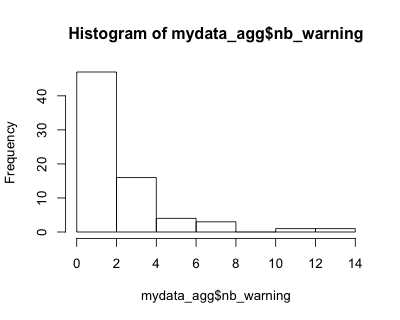

In [8]:
options(repr.plot.width = 5)
hist(mydata_agg$nb_warning)
options(repr.plot.width = 10)

nb_warnings are count data and are obvioulsy not normally distributed.  
We will use ART or a Generalized Linear Mixed Models to analysis it.

### nb_warnings: descriptive stats and plots of the aggregated data

In [9]:
summary_agg2 <- summaryWithBoot(mydata_agg, measurevar="nb_warning", groupvars=c("condition", "roomT"))
print(summary_agg2)

  condition roomT  N nb_warning      clow      cupp
1         0     0 12  3.2916667 2.0416667 5.6041667
2         0     1 12  3.4583333 1.9583333 6.1875000
3         1     0 12  1.3541667 0.6875000 2.3541667
4         1     1 12  1.6458333 0.9583333 2.4791667
5         2     0 12  0.3333333 0.1250000 0.6458333
6         2     1 12  1.4583333 0.8958333 2.5000000


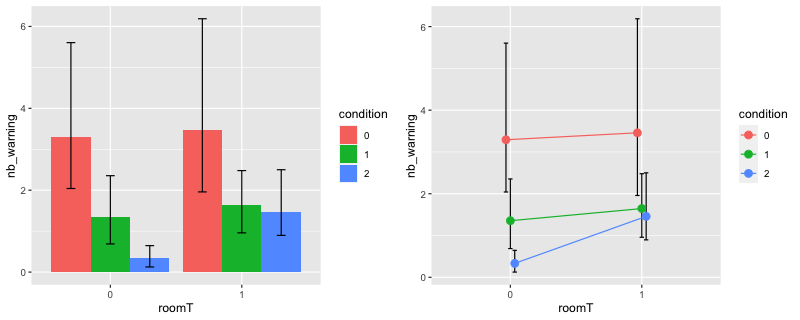

In [10]:
ggplot(summary_agg2, aes(x=roomT, y=nb_warning, fill=condition)) +
geom_bar(stat="identity", position=position_dodge()) +
geom_errorbar(aes(ymin=clow, ymax=cupp),
                  width=.2,                    # Width of the error bars
                  position=position_dodge(.9)) -> p1

# The errorbars overlapped, so use position_dodge to move them horizontally
pd <- position_dodge(0.1) # move them .05 to the left and right
ggplot(summary_agg2, aes(x=roomT, y=nb_warning, colour=condition, group=condition)) + 
    geom_errorbar(aes(ymin=clow, ymax=cupp), colour="black", width=.1, position=pd) +
    geom_line(position=pd) +
    geom_point(position=pd, size=3) -> p2

grid.arrange(p1, p2, ncol = 2)

### nb_warnings: analysis with Aligned Rank Transfrom (ART) - Solution 1

In [11]:
mod.art <- art(nb_warning ~ condition * roomT + (1|id), data=mydata_agg)
print(anova(mod.art))

Analysis of Variance of Aligned Rank Transformed Data

Table Type: Analysis of Deviance Table (Type III Wald F tests with Kenward-Roger df) 
Model: Mixed Effects (lmer)
Response: art(nb_warning)

                       F Df Df.res     Pr(>F)    
1 condition       8.8397  2     55 0.00046897 ***
2 roomT           1.6220  1     55 0.20816942    
3 condition:roomT 0.5138  2     55 0.60106291    
---
Signif. codes:   0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1 


There is main significant effect of condition F(2,55) = 8.84, p = 0.0002)

#### Post Hoc for the ART method

In [12]:
lsmeans(artlm(mod.art, "condition"), pairwise ~ condition)

NOTE: Results may be misleading due to involvement in interactions



$lsmeans
 condition lsmean   SE   df lower.CL upper.CL
 0           48.0 4.45 29.6     38.9     57.0
 1           34.2 4.45 29.6     25.1     43.3
 2           27.4 4.45 29.6     18.3     36.5

Results are averaged over the levels of: roomT 
Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$contrasts
 contrast estimate   SE df t.ratio p.value
 0 - 1       13.79 4.99 55 2.765   0.0208 
 0 - 2       20.58 4.99 55 4.126   0.0004 
 1 - 2        6.79 4.99 55 1.361   0.3681 

Results are averaged over the levels of: roomT 
Degrees-of-freedom method: kenward-roger 
P value adjustment: tukey method for comparing a family of 3 estimates 


C0 is significantly different than C1 (p = 0.021)  
C0 is significantly different than C2 (p = 0.0004)  
No effect between C1 and C2

_**/!\ Results are different from the standard analysis! I am not sure which one is best...  
Maybe this one is not totally right according to the graph and confidence interval?**_

### nb_warnings: analysis with Generalized Linear Mixed Models - Solution 2

In [13]:
mydata_agg$nb_warning <- mydata_agg$nb_warning + 0.001

contrasts(mydata_agg$condition) <- "contr.sum"
contrasts(mydata_agg$roomT) <- "contr.sum"

m <- glmer(nb_warning ~ condition * roomT + (1|id), data=mydata_agg, family = Gamma(link="log"))
res.glmm <- Anova(m, type=3)
print(res.glmm)

boundary (singular) fit: see ?isSingular



Analysis of Deviance Table (Type III Wald chisquare tests)

Response: nb_warning
                  Chisq Df Pr(>Chisq)    
(Intercept)      6.9795  1  0.0082448 ** 
condition       16.3962  2  0.0002752 ***
roomT            3.2489  1  0.0714699 .  
condition:roomT  4.0563  2  0.1315788    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


There is main significant effect of condition (X^2(2, N=?), p = 0.0002)

#### Post Hoc with a Friedman test for Post Hoc analysis on data aggregated by condition

In [14]:
pairwise.wilcox.test(mydata_agg2$nb_warning,mydata_agg2$condition,p.adjust.method="bonferroni",paired=T)

Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with zeroes”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with zeroes”



	Pairwise comparisons using Wilcoxon signed rank test 

data:  mydata_agg2$nb_warning and mydata_agg2$condition 

  0     1    
1 0.062 -    
2 0.034 0.378

P value adjustment method: bonferroni 

C0 is significantly different than C2 (p = 0.034)  
No other effects.

_**/!\ Results are the same than with the standard analysis!**_

---

# Analysis of NB_teleportation

### nb_teleportation: checking the distribution

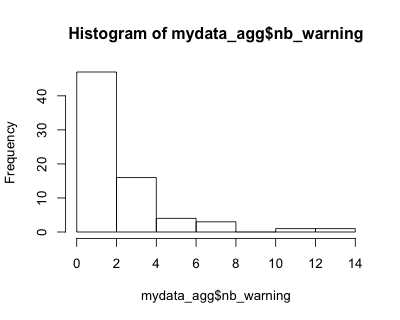

In [15]:
options(repr.plot.width = 5)
hist(mydata_agg$nb_warning)
options(repr.plot.width = 10)

nb_teleportation are count data and are obvioulsy not normally distributed.  
We will use a Generalized Linear Mixed Models or ART to analysis it.

### nb_teleportation: descriptive stats and plots of the aggregated data

In [16]:
summary_agg3 <- summaryWithBoot(mydata_agg, measurevar="nb_teleportation", groupvars=c("condition", "roomT"))
print(summary_agg3)

  condition roomT  N nb_teleportation      clow      cupp
1         0     0 12        20.583333 14.520833 37.852027
2         0     1 12        17.416667 11.562500 35.248089
3         1     0 12         2.666667  2.312500  3.166667
4         1     1 12         3.333333  2.854167  4.229167
5         2     0 12         2.583333  2.270833  3.145833
6         2     1 12         4.479167  3.437500  5.687500


In [17]:
ggplot(summary_agg3, aes(x=roomT, y=nb_teleportation, fill=condition)) +
geom_bar(stat="identity", position=position_dodge()) +
geom_errorbar(aes(ymin=clow, ymax=cupp),
                  width=.2,                    # Width of the error bars
                  position=position_dodge(.9)) -> p1

# The errorbars overlapped, so use position_dodge to move them horizontally
pd <- position_dodge(0.1) # move them .05 to the left and right
ggplot(summary_agg3, aes(x=roomT, y=nb_teleportation, colour=condition, group=condition)) + 
    geom_errorbar(aes(ymin=clow, ymax=cupp), colour="black", width=.1, position=pd) +
    geom_line(position=pd) +
    geom_point(position=pd, size=3) -> p2

grid.arrange(p1, p2, ncol = 2)

### nb_teleportation: analysis with Aligned Rank Transfrom (ART) - Solution 1

In [18]:
mod.art2 <- art(nb_teleportation ~ condition * roomT + (1|id), data=mydata_agg)
print(anova(mod.art2))

Analysis of Variance of Aligned Rank Transformed Data

Table Type: Analysis of Deviance Table (Type III Wald F tests with Kenward-Roger df) 
Model: Mixed Effects (lmer)
Response: art(nb_teleportation)

                         F Df Df.res     Pr(>F)    
1 condition       90.39597  2     55 < 2.22e-16 ***
2 roomT            0.51961  1     55  0.4740618    
3 condition:roomT  5.95361  2     55  0.0045653  **
---
Signif. codes:   0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1 


There is main significant effect of condition F(2,55) = 90.40, p < 0.0001)  
No main effect on roomT => which is better !  
Interaction effect of condition X roomT F(2,55) = 5.95, p = 0.0045)

#### Post Hoc for the ART method

_**Main effect of condition**_

In [19]:
lsmeans(artlm(mod.art2, "condition"), pairwise ~ condition)

NOTE: Results may be misleading due to involvement in interactions



$lsmeans
 condition lsmean   SE   df lower.CL upper.CL
 0           60.3 2.75 30.4     54.7     65.9
 1           20.6 2.75 30.4     15.0     26.2
 2           28.6 2.75 30.4     23.0     34.2

Results are averaged over the levels of: roomT 
Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$contrasts
 contrast estimate   SE df t.ratio p.value
 0 - 1       39.67 3.12 55 12.715  <.0001 
 0 - 2       31.65 3.12 55 10.144  <.0001 
 1 - 2       -8.02 3.12 55 -2.571  0.0339 

Results are averaged over the levels of: roomT 
Degrees-of-freedom method: kenward-roger 
P value adjustment: tukey method for comparing a family of 3 estimates 


C0 is significantly different than C1 (p < 0.0001) and C2 (p < 0.0001)  
Significantly difference between C1 and C2 (p = 0.034) => does not seems right!

_**Interaction effect of condition X roomT**_

In [20]:
library(phia)
res <- testInteractions(artlm(mod.art2, "condition:roomT"), pairwise=c("condition","roomT"), adjustment="holm")
print(res)

Chisq Test: 
P-value adjustment method: holm
           Value Df   Chisq Pr(>Chisq)   
0-1 : 0-1 19.917  1  4.2564   0.078206 . 
0-2 : 0-1 33.083  1 11.7443   0.001831 **
1-2 : 0-1 13.167  1  1.8602   0.172602   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [21]:
# cross-factor pairwise comparisons using Wilcoxon signed-rank tests.
# we don't have to do all six possible comparisons over X1=(a,b),
# X2=(d,e), but we do so below for completeness. Note each comparison
# assumes subjects were in both of the compared conditions.
library(reshape2)
mydata_wide <- dcast(mydata_agg, id ~ condition + roomT, value.var="nb_teleportation") # make wide-format table
c00_vs_c10 = wilcox.test(mydata_wide$`0_0`, mydata_wide$`1_0`, paired=TRUE)$p.value
c00_vs_c20 = wilcox.test(mydata_wide$`0_0`, mydata_wide$`2_0`, paired=TRUE)$p.value
c10_vs_c20 = wilcox.test(mydata_wide$`1_0`, mydata_wide$`2_0`, paired=TRUE)$p.value
c01_vs_c11 = wilcox.test(mydata_wide$`0_1`, mydata_wide$`1_1`, paired=TRUE)$p.value
c01_vs_c21 = wilcox.test(mydata_wide$`0_1`, mydata_wide$`2_1`, paired=TRUE)$p.value
c11_vs_c21 = wilcox.test(mydata_wide$`1_1`, mydata_wide$`2_1`, paired=TRUE)$p.value
c00_vs_c01 = wilcox.test(mydata_wide$`0_0`, mydata_wide$`0_1`, paired=TRUE)$p.value
c10_vs_c11 = wilcox.test(mydata_wide$`1_0`, mydata_wide$`1_1`, paired=TRUE)$p.value
c20_vs_c21 = wilcox.test(mydata_wide$`2_0`, mydata_wide$`2_1`, paired=TRUE)$p.value

# correct for multiple comparisons using Holm's sequential Bonferroni procedure (Holm 1979)
p.adjust(c(c00_vs_c10, c00_vs_c20, c10_vs_c20, 
           c01_vs_c11, c01_vs_c21, c11_vs_c21,
           c00_vs_c01, c10_vs_c11, c20_vs_c21), method="holm")

Warning message in wilcox.test.default(mydata_wide$`0_0`, mydata_wide$`1_0`, paired = TRUE):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mydata_wide$`0_0`, mydata_wide$`2_0`, paired = TRUE):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mydata_wide$`1_0`, mydata_wide$`2_0`, paired = TRUE):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mydata_wide$`1_0`, mydata_wide$`2_0`, paired = TRUE):
“cannot compute exact p-value with zeroes”
Warning message in wilcox.test.default(mydata_wide$`0_1`, mydata_wide$`2_1`, paired = TRUE):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mydata_wide$`1_1`, mydata_wide$`2_1`, paired = TRUE):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mydata_wide$`1_1`, mydata_wide$`2_1`, paired = TRUE):
“cannot compute exact p-value with zeroes”
Warning message in wilcox.test.default(mydata_wide$`0_0`, 

[1] 0.020131973 0.020131973 0.903917310 0.004394531 0.020131973 0.283552634
[7] 0.126286118 0.221780198 0.221780198

### nb_teleportation: analysis with Generalized Linear Mixed Models - Solution 2

In [22]:
contrasts(mydata_agg$condition) <- "contr.sum"
contrasts(mydata_agg$roomT) <- "contr.sum"

m <- glmer(nb_teleportation ~ condition * roomT + (1|id), data=mydata_agg, family = Gamma(link="log"))
res.glmm <- Anova(m, type=3)
print(res.glmm)

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: nb_teleportation
                   Chisq Df Pr(>Chisq)    
(Intercept)     221.8062  1  < 2.2e-16 ***
condition       292.4236  2  < 2.2e-16 ***
roomT             3.9085  1   0.048043 *  
condition:roomT  10.4367  2   0.005416 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


There is main significant effect of condition (X^2(2,N=?) = 8.84, p < 0.0001)  
_**I cannot trust the main effect on roomT (see graph above)**_ (X^2(1,N=?) = 8.84, p < 0.048)  
Interaction effect of condition X roomT (X^2(2,N=?) = 8.84, p < 0.0054)  


#### Post Hoc analysis

_**Main effect of condition : Friedman test for Post Hoc analysis on data aggregated by condition**_

Loading required package: coin

Loading required package: colorspace



$Friedman.Test

	Asymptotic General Symmetry Test

data:  nb_teleportation by condition (0, 1, 2) 
	 stratified by id
maxT = 4.2866, p-value = 6.132e-05
alternative hypothesis: two.sided


$PostHoc.Test
                  
1 - 0 4.852914e-05
2 - 0 6.202867e-03
2 - 1 4.384688e-01


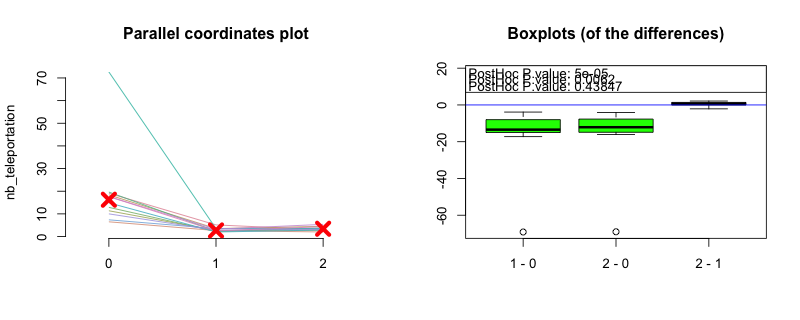

In [23]:
friedman.test.with.post.hoc(nb_teleportation ~ condition | id, data=mydata_agg2)

C0 is significantly different than C1 (p < 0.0001) and C2 (p = 0.0063)  
No difference between C1 and C2

_**Main effect of roomT : Wilcoxon signed-R-rank test**_

In [24]:
wilcoxsign_test(nb_teleportation ~ roomT | id, data=mydata_agg3, dist="exact")


	Exact Wilcoxon-Pratt Signed-Rank Test

data:  y by x (pos, neg) 
	 stratified by block
Z = 0.74668, p-value = 0.4814
alternative hypothesis: true mu is not equal to 0


_which confirm the issue in the test with the Generalized Linear Mixed Model !!!_

_**Interaction effect of condition X roomT**_

Not sure how to do that? and maybe not so interresting?